# Glauber on infinite random $k$-regular graph
Compute magnetization in the thermodynamic limit $N\to\infty$.

Reproduce the results in *Barthel et. al*, [Matrix product algorithm for stochastic dynamics on networks applied to nonequilibrium Glauber dynamics](https://doi.org/10.1103/PhysRevE.97.010104) for $T=50, J=β=1, h=0, m⁰ = 0.5, k=3$.

In [1]:
using MatrixProductBP, MatrixProductBP.Models
using Graphs, IndexedGraphs, Plots, LaTeXStrings
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

In [92]:
T = 30         # final time
k = 3          # degree
m⁰ = 0.5       # magnetization at time zero

β = 1.0
J = 1.0
h = 0.0;

In [93]:
wᵢ = fill(HomogeneousGlauberFactor(J, h, β), T+1)
ϕᵢ = [ t == 0 ? [(1+m⁰)/2, (1-m⁰)/2] : ones(2) for t in 0:T]
bp = mpbp_infinite_graph(k, wᵢ, 2, ϕᵢ)
cb = CB_BP(bp);

In [94]:
matrix_sizes = [5, 15]
maxiters = fill(50, length(matrix_sizes))
iters = zeros(Int, length(maxiters))
tol = 1e-4
for i in eachindex(maxiters)
    iters[i], _ = iterate!(bp; maxiter=maxiters[i], svd_trunc=TruncBond(matrix_sizes[i]), cb, tol)
end

Running MPBP: iter 51 	 Time: 0:04:12
  Δ:                7.772065415045937e-5
  SVD Matrix size:  15

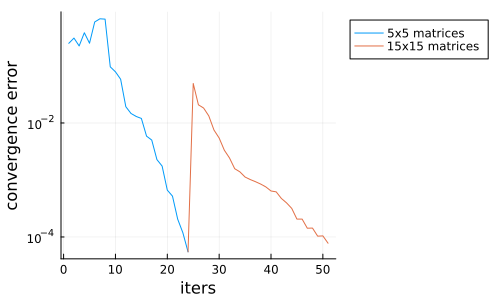

In [95]:
iters_cum = cumsum(iters)
inds = 1:iters_cum[1]
pl = plot(inds, cb.Δs[inds], label="$(matrix_sizes[1])x$(matrix_sizes[1]) matrices")
for i in 2:length(iters)
    inds = iters_cum[i-1]:iters_cum[i]
   plot!(pl, inds, cb.Δs[inds], label="$(matrix_sizes[i])x$(matrix_sizes[i]) matrices")
end
plot(pl, ylabel="convergence error", xlabel="iters", yaxis=:log10, size=(500,300), legend=:outertopright)

In [96]:
spin(x, i) = 3-2x
spin(x) = spin(x, 0)
m = only(means(spin, bp));

In [97]:
pb = pair_beliefs_as_mpem(bp)[1][1]
compress!(pb; svd_trunc=TruncBond(15))
mtu = marginals_tu(pb; Δtmax=1)
r = [expectation(spin, dropdims(sum(sum(mtu[t,t+1], dims=2), dims=3); dims=(2,3))) 
    for t in 1:T];

In [98]:
m_eq, r_eq, e_eq = equilibrium_observables(RandomRegular(k), J; β, h)

(m = 0.9917570032084977, r = 0.9861516673634358, e = -1.4792275010451537)

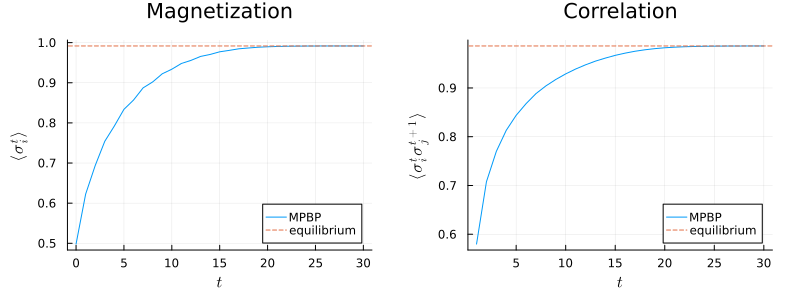

In [99]:
pl_m = plot(0:T, m, xlabel=L"t", ylabel=L"\langle \sigma_i^t \rangle", msc=:auto,
    size=(500,300), xticks=0:5:T, ms=2, label="MPBP", legend=:bottomright)
hline!(pl_m, [m_eq], label="equilibrium", ls=:dash, title="Magnetization")

pl_r = plot(1:T, r, xlabel=L"t", ylabel=L"\langle \sigma_i^t\sigma_j^{t+1} \rangle", msc=:auto,
    size=(500,300), xticks=0:5:T, ms=2, label="MPBP", legend=:bottomright)
hline!(pl_r, [r_eq], label="equilibrium", ls=:dash, title="Correlation")

plot(pl_m, pl_r, size=(800,300), margin=5Plots.mm)

In [100]:
using Statistics
import Measurements: value
N = 10^3
g = random_regular_graph(N, k)
ising = Ising(IndexedGraph(g); J=fill(J, ne(g)), h=fill(h, N), β)
bp_mc = mpbp(Glauber(ising, T); ϕ = fill(ϕᵢ, N))
sms = SoftMarginSampler(bp_mc);

In [101]:
sample!(sms, 10^3);

SoftMargin sampling 100%|████████████████████████████████| Time: 0:00:06


In [102]:
c_mc_ = autocovariances(spin, sms)
c_mc = [[value(x) for x in xx] for xx in c_mc_];

Autocorrelations from Soft Margin 100%|██████████████████| Time: 0:00:28
Marginals from Soft Margin 100%|█████████████████████████| Time: 0:00:01


In [103]:
c = autocovariances(bp);

In [104]:
plot_autocovs(args...; kw...) = plot_autocovs!(plot(), args...; kw...)
function plot_autocovs!(pl, c; skip_even=false, T=size(c,1)-1, ΔT=1.0, 
        us=0:(2*floor(Int, T/10)):T, cg = cgrad(:matter, length(us)+1, categorical=true), 
        kw...)
    step = skip_even ? 2 : 1
    ylabel = L"\langle x_{i}^t x_{i}^{s}\rangle-\langle x_{i}^t\rangle\langle x_{i}^{s}\rangle"
    xlabel = L"t-s"
    plot!(pl; xlabel, ylabel, legend=:outertopright)
     
    for (j,u) in enumerate(us)
        plot!(pl, (u:-step:1).*ΔT, c[(0:step:u-1) .+ 1,u+1], label="t=$(Int(u*ΔT))", #label="t+Δt=$(Int(u*ΔT))", 
            c=cg[j+1], msc=:auto; kw...) 
    end
    pl
end 

plot_autocovs! (generic function with 1 method)

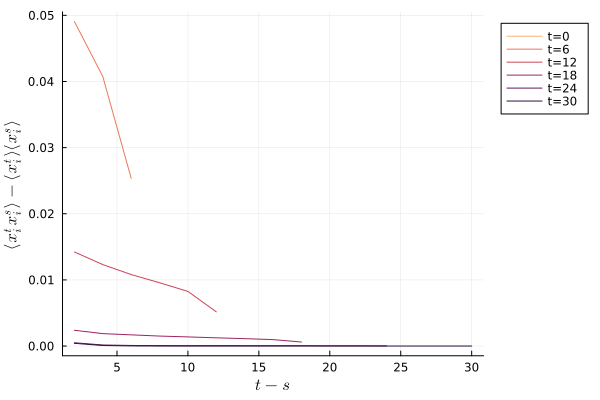

In [105]:
skip_even = true
pl = plot_autocovs(mean(c); skip_even)
# plot_autocovs!(pl, mean(c_mc); st=:scatter, skip_even)